In [ ]:
import math
import os
import random
import torch
from d2l import torch as d2l
import hashlib
import zipfile
import collections
import requests

In [ ]:
def download_extract(name, folder=None):
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    fp = zipfile.ZipFile(fname, 'r')
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

In [ ]:
def download(url, folder='corpus', sha1_hash=None):
  if not url.startswith('http'):
    url, sha1_hash = DATA_HUB[url]
  os.makedirs(folder, exist_ok=True)
  fname = os.path.join(folder, url.split('/')[-1])
  if os.path.exists(fname) and sha1_hash:
    sha1 = hashlib.sha1()
    with open(fname, 'rb') as f:
      while True:
        corpus = f.read()
        if not corpus:
          break
        sha1.update(corpus)
    if sha1.hexdigest() == sha1_hash:
      return fname
  print(f'Downloading {fname} from {url}')
  r = requests.get(url, stream=True, verify=True)
  with open(fname, 'wb') as f:
    f.write(r.content)
  return fname

In [ ]:
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
DATA_HUB = dict()
DATA_HUB['ptb'] = (DATA_URL + 'ptb.zip','319d85e578af0cdc590547f26231e4e31cdf1e42')

In [ ]:
def corpus_read():
  data_dir = download_extract('ptb')
  with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
    raw_text = f.read()
  return [line.split() for line in raw_text.split('\n')]
sentences = corpus_read()

In [ ]:
class Vocab:
    def __init__(self, tokens=[], min_frequency=0, reserved_tokens=[]):

        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        counter = collections.Counter(tokens)
        self.token_frequency = sorted(counter.items(), key=lambda x: x[1],reverse=True)
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [token for token, frequency in self.token_frequency if frequency >= min_frequency])))
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
    def __len__(self):
        return len(self.idx_to_token)
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]
    @property
    def unk(self): #for uknown token
        return self.token_to_idx['<unk>']
vocab = Vocab(sentences, min_frequency=10)

In [ ]:
def corpus_count(tokens):
    if len(tokens) == 0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [ ]:
def subsampling(sentences, vocab):
    sentences = [[token for token in line if vocab[token] != vocab.unk] for line in sentences]
    counter = corpus_count(sentences)
    num_tokens = sum(counter.values())
    def keep(token):
        return (random.uniform(0, 1) < math.sqrt(1e-4 / counter[token] * num_tokens))
    return ([[token for token in line if keep(token)] for line in sentences], counter)
subsampled, counter = subsampling(sentences, vocab)
corpus = [vocab[line] for line in subsampled]

In [ ]:
def get_centers_and_contexts(corpus, max_window_size):
    centers, contexts = [], []
    for line in corpus:
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)): 
            window_size = max_window_size 
            indices = list(range(max(0, i - window_size),min(len(line), i + 1 + window_size)))
            indices.remove(i)
            contxt = [line[idx] for idx in indices]
            contexts.append(contxt)
    return centers, contexts
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)

In [ ]:
#Negative Sampling
class RandomGenerator:
    def __init__(self, sampling_weights):
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0
    def draw(self):
        if self.i == len(self.candidates):
            self.candidates = random.choices(self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]

In [ ]:
def get_negatives(all_contexts, vocab, counter, N):
    sampling_weights = [ counter[vocab.to_tokens(i)]**0.75 for i in range(1, len(vocab))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * N:
            neg = generator.draw()
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives
all_negatives = get_negatives(all_contexts, vocab, counter, 6)

In [ ]:
def generate_batches(data):
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(contexts_negatives), torch.tensor(masks),torch.tensor(labels))

In [ ]:
def words_data_load(batch_size, max_window_size, num_noise_words):
    num_workers = d2l.get_dataloader_workers()
    
    class Words(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives
        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index], self.negatives[index])
        def __len__(self):
            return len(self.centers)
    dataset = Words(all_centers, all_contexts, all_negatives)
    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, collate_fn=generate_batches, num_workers=num_workers)
    return data_iter, vocab

In [ ]:
import math
import torch
from torch import nn
from d2l import torch as d2l
batch_size, max_window_size, num_noise_words = 422, 6, 5
data_iter, vocab = words_data_load(batch_size, max_window_size,num_noise_words)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
embedd = nn.Embedding(num_embeddings=30, embedding_dim=4)
print(f'Parameter embedding_weight ({embedd.weight.shape}, 'f'dtype={embedd.weight.dtype})')
def skip_gram(center, contexts_and_negatives, embedd_v, embedd_u):
    v = embedd_v(center)
    u = embedd_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred
skip_gram(torch.ones((2, 1), dtype=torch.long),torch.ones((2, 4), dtype=torch.long), embedd, embedd).shape
embedd_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab), embedding_dim=embedd_size),nn.Embedding(num_embeddings=len(vocab), embedding_dim=embedd_size))

Parameter embedding_weight (torch.Size([30, 4]), dtype=torch.float32)


In [ ]:
class SigmoidBCELoss(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self, inputs, target, mask=None):
    out = nn.functional.binary_cross_entropy_with_logits(inputs, target, weight=mask, reduction="none")
    return out.mean(dim=1)
loss = SigmoidBCELoss()

In [ ]:
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
    def init_weights(m):
        if type(m) == nn.Embedding:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',xlim=[1, num_epochs])
    metric = d2l.Accumulator(2)
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [data.to(device) for data in batch]
            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask) / mask.sum(axis=1) * mask.shape[1]) 
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
              animator.add(epoch + (i + 1) / num_batches,(metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, 'f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

loss 0.380, 50310.9 tokens/sec on cpu


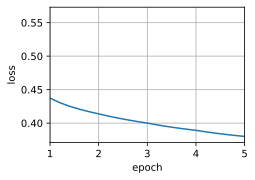

In [166]:
lr, num_epochs= 0.002, 5
train(net, data_iter,lr,num_epochs)

In [167]:
def get_similar_tokens(known_token, k, embedd):
    W = embedd.weight.data
    x = W[vocab[known_token]]
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) * torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k + 1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]: 
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

In [175]:
get_similar_tokens('mature', 3, net[1])

cosine sim=0.851: dated
cosine sim=0.829: franc
cosine sim=0.809: maturing
